In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import joblib
from torchsummary import summary


import wandb

## Initial settings

In [55]:
num_epochs = 150  # Adjust the number of training epochs
lr=0.001
batch_size=32

ntimesteps = 30

t0 = time.time()

print(t0)

root_path = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/'

1707923092.452121


## Load data

In [56]:
concatenated_data = np.load(root_path + "Flow_Data/InterpolatedResult256/concatenated_data-1_1.npy")
# concatenated_data = np.load("/home/dg321/gitTest/PRI/irp/Flow_Data/InterpolatedResult256/sampelXs_stacked.npy")
# # data = concatenated_data[200:255,:,:,0]
# data = concatenated_data[200:255,:,:]

concatenated_data = concatenated_data.reshape(450, 2, 256, 256)

concatenated_data_list = []

dt = 5

for i in range(50):
    cd = concatenated_data[1 + i*dt,:,:, :]
    print(1 + i*dt)
    concatenated_data_list.append(cd)
data = np.stack(concatenated_data_list)

print(data.shape)

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
101
106
111
116
121
126
131
136
141
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
(50, 2, 256, 256)


## Create data loader

In [57]:
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

## Define the model

In [125]:
fist_hidden_layer = 64
second_hidden_layer = 128


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(fist_hidden_layer, 8, kernel_size=2, stride=1, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(fist_hidden_layer, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [126]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (2,256, 256))
summary(autoencoder, (2,384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             576
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]          32,896
              ReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5           [-1, 64, 65, 65]          32,832
              ReLU-6           [-1, 64, 65, 65]               0
            Conv2d-7            [-1, 8, 64, 64]           2,056
              ReLU-8            [-1, 8, 64, 64]               0
   ConvTranspose2d-9           [-1, 64, 65, 65]           2,112
             ReLU-10           [-1, 64, 65, 65]               0
  ConvTranspose2d-11          [-1, 128, 64, 64]          32,896
             ReLU-12          [-1, 128, 64, 64]               0
  ConvTranspose2d-13         [-1, 64, 128, 128]          32,832
             ReLU-14         [-1, 64, 1

## Train the model

In [124]:
# Initialize a new run
wandb.init(project="compression")

# Instantiate the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss works well for image reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

num_epochs = 1200

# Optionally, you can add the following line to watch your model in wandb interface
wandb.watch(autoencoder)

# Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        inputs = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Log the loss to wandb
    wandb.log({"loss": loss.item()})

print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.0513


2024-02-14 15:39:30.981643: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch [1/1200], Loss: 0.2945
Epoch [2/1200], Loss: 0.2830
Epoch [3/1200], Loss: 0.2769
Epoch [4/1200], Loss: 0.2667
Epoch [5/1200], Loss: 0.2591
Epoch [6/1200], Loss: 0.2465
Epoch [7/1200], Loss: 0.2351
Epoch [8/1200], Loss: 0.2360
Epoch [9/1200], Loss: 0.2287
Epoch [10/1200], Loss: 0.2269
Epoch [11/1200], Loss: 0.2263
Epoch [12/1200], Loss: 0.2265
Epoch [13/1200], Loss: 0.2141
Epoch [14/1200], Loss: 0.2195
Epoch [15/1200], Loss: 0.2123
Epoch [16/1200], Loss: 0.2034
Epoch [17/1200], Loss: 0.1966
Epoch [18/1200], Loss: 0.2067
Epoch [19/1200], Loss: 0.1959
Epoch [20/1200], Loss: 0.2028
Epoch [21/1200], Loss: 0.1998
Epoch [22/1200], Loss: 0.1958
Epoch [23/1200], Loss: 0.1888
Epoch [24/1200], Loss: 0.1905
Epoch [25/1200], Loss: 0.1822
Epoch [26/1200], Loss: 0.1802
Epoch [27/1200], Loss: 0.1797
Epoch [28/1200], Loss: 0.1817
Epoch [29/1200], Loss: 0.1719
Epoch [30/1200], Loss: 0.1737
Epoch [31/1200], Loss: 0.1713
Epoch [32/1200], Loss: 0.1684
Epoch [33/1200], Loss: 0.1614
Epoch [34/1200], Lo

## Load saved model

In [127]:
run = wandb.init()
artifact = run.use_artifact('guodh/compression/model:v4', type='model')
artifact_dir = artifact.download()

# Load the model
autoencoder = Autoencoder()

# Load the model state dictionary from the downloaded artifact
autoencoder.load_state_dict(torch.load(os.path.join(artifact_dir, "autoencoder.pth")))

loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.05625


2024-02-14 15:44:23.543461: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<All keys matched successfully>

## Generate result plots

(2, 256, 256) 131072
latent space shape torch.Size([1, 8, 64, 64]) 32768
(1, 2, 256, 256)


<Figure size 432x288 with 0 Axes>

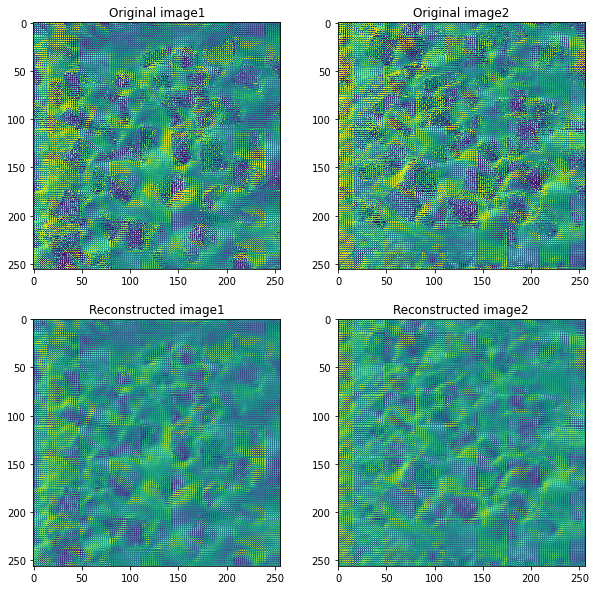

In [128]:
autoencoder.cpu().eval()

# Testing set

# dataP = samples_2steps[0]
dataP = concatenated_data[10]
# dataP = data[:2]
print(dataP.shape, dataP.shape[-1]*dataP.shape[-2]*dataP.shape[-3])

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(10, 10))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')

sub2 = axarr[0][1].imshow(np.rot90(dataP[1, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 2, 256, 256))
print('latent space shape', latent_space_output.shape, latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3])
res = autoencoder(input_data.view(1, 2, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')

sub4 = axarr[1][1].imshow(output_data[0,1, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')

In [129]:
datasetFolder = 'Flow_Data'
xysize = 256

samples = []
for i in range(ntimesteps):
    s = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/InterpolatedResult256/InterpolatedResult256Raw/FpB_Interpolated_t{}_Velocity_{}_{}.npy'.format(
        i, xysize, xysize))
    samples.append(s)
    # print(s.shape)

(2, 256, 256) 131072
latent space shape torch.Size([1, 8, 64, 64]) 32768
(1, 2, 256, 256)


<Figure size 432x288 with 0 Axes>

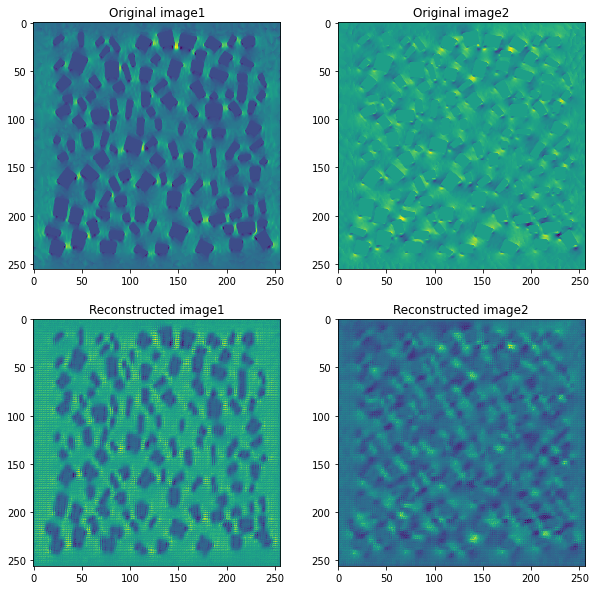

In [130]:
# Testing set

# dataP = samples_2steps[0]
dataP = samples[10]
# dataP = data[:2]
print(dataP.shape, dataP.shape[-1]*dataP.shape[-2]*dataP.shape[-3])

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(10, 10))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')

sub2 = axarr[0][1].imshow(np.rot90(dataP[1, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 2, 256, 256))
print('latent space shape', latent_space_output.shape, latent_space_output.shape[-1]*latent_space_output.shape[-2]*latent_space_output.shape[-3])
res = autoencoder(input_data.view(1, 2, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')

sub4 = axarr[1][1].imshow(output_data[0,1, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')